In [25]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def preprocess_data(ruta_csv, caso):

    """
    This function applies different preprocessing modes: 'simple', '1stderivative', '2nderivative', and 'concatenate'.

    Parameters:
    -----------
    ruta_csv : str
        Path to the CSV file containing the data to be preprocessed.
    caso : str
        The preprocessing mode to apply. Options include:
        - 'simple': No additional processing; return the data as is.
        - '1stderivative': Calculate the first derivative of the spectral data.
        - '2nderivative': Calculate the second derivative of the spectral data.
        - 'concatenate': Concatenate the original data with the first and second derivatives.

    Returns:
    --------
    pandas.DataFrame
        The preprocessed DataFrame. Categorical columns are preserved in the output for all cases.
    """


    filtered_data = pd.read_csv(ruta_csv)
    #filtered_data = filtered_data.sample(n=500, random_state=42)
    
    if caso == 'simple':
        return filtered_data
    
    categorical_columns = ['especie', 'name', 't_exp', 'date', 'medium']
    data_without_especie = filtered_data.drop(columns=categorical_columns)
    
    if caso == '1stderivative':
        first_derivative = data_without_especie.diff(axis=1).iloc[:, 1:-1]
        first_derivative[categorical_columns] = filtered_data[categorical_columns]
        return first_derivative
    
    if caso == '2nderivative':
        first_derivative = data_without_especie.diff(axis=1).iloc[:, 1:-1]
        second_derivative = first_derivative.diff(axis=1).iloc[:, 1:-1]
        second_derivative[categorical_columns] = filtered_data[categorical_columns]
        return second_derivative
    
    if caso == 'concatenate':
        return filtered_data
    

In [18]:
def main(ruta_csv_corrected_trainval, ruta_csv_corrected_test, ruta_csv_baselines_trainval, ruta_csv_baselines_test, 
         ruta_csv_originals_trainval, ruta_csv_originals_test, target_column, save_path, nombre, caso):

    # Preprocess the three datasets according to the specified case (simple, first, or second derivative)
    corrected_data_trainval = preprocess_data(ruta_csv_corrected_trainval, caso)
    corrected_data_test = preprocess_data(ruta_csv_corrected_test, caso)
    baselines_data_trainval = preprocess_data(ruta_csv_baselines_trainval, caso)
    baselines_data_test = preprocess_data(ruta_csv_baselines_test, caso)
    originals_data_trainval = preprocess_data(ruta_csv_originals_trainval, caso)
    originals_data_test = preprocess_data(ruta_csv_originals_test, caso)

    # List of categorical columns to remove
    categorical_columns = ['X', 'Y', 'name', 't_exp', 'date', 'medium']

    # Exclude the categorical columns from the data
    corrected_data_trainval = corrected_data_trainval.drop(columns=categorical_columns)
    corrected_data_test = corrected_data_test.drop(columns=categorical_columns)
    baselines_data_trainval = baselines_data_trainval.drop(columns=categorical_columns)
    baselines_data_test = baselines_data_test.drop(columns=categorical_columns)
    originals_data_trainval = originals_data_trainval.drop(columns=categorical_columns)
    originals_data_test = originals_data_test.drop(columns=categorical_columns)

    # Create the folder with the specified name
    folder_path = os.path.join(save_path, f"{nombre}")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder {folder_path} created to save files.")
    else:
        print(f"Folder {folder_path} already exists.")

    # Balance the trainval dataset
    all_classes = corrected_data_trainval[target_column].unique()
    minority_class_size = corrected_data_trainval[target_column].value_counts().min()
    target_class_size = int(minority_class_size * 1.2)  # Increase minority class size by 20%

    balanced_corrected_trainval = pd.DataFrame()
    balanced_baselines_trainval = pd.DataFrame()
    balanced_originals_trainval = pd.DataFrame()

    for class_name in all_classes:
        class_samples_corrected = corrected_data_trainval[corrected_data_trainval[target_column] == class_name]
        class_samples_baselines = baselines_data_trainval[baselines_data_trainval[target_column] == class_name]
        class_samples_originals = originals_data_trainval[originals_data_trainval[target_column] == class_name]

        if class_samples_corrected.shape[0] > target_class_size:
            reduced_samples_corrected = class_samples_corrected.sample(n=target_class_size, random_state=1000)
            reduced_samples_baselines = class_samples_baselines.loc[reduced_samples_corrected.index]
            reduced_samples_originals = class_samples_originals.loc[reduced_samples_corrected.index]
        else:
            reduced_samples_corrected = class_samples_corrected
            reduced_samples_baselines = class_samples_baselines
            reduced_samples_originals = class_samples_originals

        balanced_corrected_trainval = pd.concat([balanced_corrected_trainval, reduced_samples_corrected])
        balanced_baselines_trainval = pd.concat([balanced_baselines_trainval, reduced_samples_baselines])
        balanced_originals_trainval = pd.concat([balanced_originals_trainval, reduced_samples_originals])

    # Show the number of samples per class in the balanced trainval dataset
    print(f"Number of samples per class in the balanced trainval set based on {target_column}:")
    print(balanced_corrected_trainval[target_column].value_counts())

    # Separate features (X) and labels (y)
    X_train_corrected = balanced_corrected_trainval.drop(columns=[target_column])
    X_train_baselines = balanced_baselines_trainval.drop(columns=[target_column])
    X_train_originals = balanced_originals_trainval.drop(columns=[target_column])
    y_train = balanced_corrected_trainval[target_column]

    # Balance the test dataset
    all_classes_test = corrected_data_test[target_column].unique()
    minority_class_size_test = corrected_data_test[target_column].value_counts().min()  # Minimum number of samples in test
    target_class_size_test = int(minority_class_size_test * 1.2)  # Maximum allowed size per class in test

    # Initialize balanced DataFrames for test
    balanced_corrected_test = []
    balanced_baselines_test = []
    balanced_originals_test = []

    for class_name in all_classes_test:
        # Filter samples by class for the test set
        class_samples_corrected_test = corrected_data_test[corrected_data_test[target_column] == class_name]
        class_samples_baselines_test = baselines_data_test[baselines_data_test[target_column] == class_name]
        class_samples_originals_test = originals_data_test[originals_data_test[target_column] == class_name]

        # Apply balancing according to the target size
        if class_samples_corrected_test.shape[0] > target_class_size_test:
            reduced_samples_corrected_test = class_samples_corrected_test.sample(n=target_class_size_test, random_state=1000)
            reduced_samples_baselines_test = class_samples_baselines_test.loc[reduced_samples_corrected_test.index]
            reduced_samples_originals_test = class_samples_originals_test.loc[reduced_samples_corrected_test.index]
        else:
            # Use all samples if they are less than the target size
            reduced_samples_corrected_test = class_samples_corrected_test
            reduced_samples_baselines_test = class_samples_baselines_test
            reduced_samples_originals_test = class_samples_originals_test

        # Add the balanced samples to the lists
        balanced_corrected_test.append(reduced_samples_corrected_test)
        balanced_baselines_test.append(reduced_samples_baselines_test)
        balanced_originals_test.append(reduced_samples_originals_test)

    # Concatenate all balanced classes
    balanced_corrected_test = pd.concat(balanced_corrected_test).reset_index(drop=True)
    balanced_baselines_test = pd.concat(balanced_baselines_test).reset_index(drop=True)
    balanced_originals_test = pd.concat(balanced_originals_test).reset_index(drop=True)

    # Show the number of samples per class in the balanced test set
    print(f"Number of samples per class in the balanced test set based on {target_column}:")
    print(balanced_corrected_test[target_column].value_counts())

    # Separate features (X) and labels (y) for the test
    X_test_corrected = balanced_corrected_test.drop(columns=[target_column])
    X_test_baselines = balanced_baselines_test.drop(columns=[target_column])
    X_test_originals = balanced_originals_test.drop(columns=[target_column])
    y_test = balanced_corrected_test[target_column]

    # Label normalization using LabelEncoder and one-hot encoding
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_train = tf.keras.utils.to_categorical(y_train_encoded)
    y_test_encoded = le.transform(y_test)
    y_test = tf.keras.utils.to_categorical(y_test_encoded)

    # Reshape the data to be compatible with the model
    X_test_corrected_reshaped = np.expand_dims(X_test_corrected.values, axis=-1)
    X_test_baselines_reshaped = np.expand_dims(X_test_baselines.values, axis=-1)
    X_test_originals_reshaped = np.expand_dims(X_test_originals.values, axis=-1)

    # Dynamically adjust input size according to the case
    input_shape_corrected = (X_train_corrected.shape[1], 1)
    input_shape_baselines = (X_train_baselines.shape[1], 1)
    input_shape_originals = (X_train_originals.shape[1], 1)

    # Define the model name
    model_filename_h5 = os.path.join(folder_path, f"model_{nombre}.h5")

    # Save metrics to a CSV file
    metrics_filename = os.path.join(folder_path, f"metrics_{nombre}.csv")

    # Save predictions to a CSV file
    test_results_filename = os.path.join(folder_path, f"test_predictions_{nombre}.csv")

    # Search for existing .h5 files in the folder
    h5_files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]

    # If there is an existing .h5 model
    if h5_files:
        model_path = os.path.join(folder_path, h5_files[0])  # Select the first file
        print(f"Model already exists. Loading model from: {model_path}")
        model = tf.keras.models.load_model(model_path)

        # Evaluate the final model on the test set
        y_pred_final = model.predict([X_test_corrected_reshaped, X_test_baselines_reshaped, X_test_originals_reshaped])
        y_pred_final_int = tf.argmax(y_pred_final, axis=1).numpy()
        y_test_int = tf.argmax(y_test, axis=1).numpy()  # y_test is one-hot encoded

        final_test_acc = accuracy_score(y_test_int, y_pred_final_int)
        print(f"Test Accuracy: {final_test_acc:.4f}")

        # Compute and display the confusion matrix
        cm = confusion_matrix(y_test_int, y_pred_final_int, labels=np.arange(len(le.classes_)))
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues',
                    xticklabels=le.inverse_transform(np.arange(len(le.classes_))),
                    yticklabels=le.inverse_transform(np.arange(len(le.classes_))))
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                value = cm[i, j]
                if value != 0 and not np.isnan(cm_normalized[i, j]):
                    text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                    text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                    plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)
        ax.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
        ax.set_ylabel('True Label', fontsize=17, labelpad=20)
        #ax.text(0.93, 0.985, '(b)', transform=ax.transAxes, fontsize=18, verticalalignment='top')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        cbar = plt.gca().collections[0].colorbar
        cbar.ax.tick_params(labelsize=13)
        plt.tight_layout()
        fig.savefig(save_path + "cm_3channels" + ".svg", format="svg", dpi=300)
        fig.savefig(save_path + "cm_3channels" + ".png", format="png", dpi=300)
        plt.show()

        # Compute per-class metrics
        class_metrics = []
        for i in range(len(le.classes_)):
            tp = cm[i, i]  # True Positives
            fn = cm[i, :].sum() - tp  # False Negatives
            tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negatives
            fp = cm[:, i].sum() - tp  # False Positives

            accuracy_class = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handling division by zero
            recall = tp / (tp + fn) if (tp + fn) != 0 else 0      # Handling division by zero
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0 # Handling division by zero
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

            # Create y_true_class one-hot encoded for the current class
            y_true_class = np.zeros((len(y_test_int),))
            y_true_class[y_test_int == i] = 1

            # Probability scores for the current class
            y_score_class = y_pred_final[:, i]

            # Calculate AUC
            auc = roc_auc_score(y_true_class, y_score_class)

            class_metrics.append({
                'Class': i,
                'Accuracy': accuracy_class,
                'Precision': precision,
                'Recall': recall,
                'Specificity': specificity,
                'F1-Score': f1_score,
                'AUC': auc
            })

        # Print class metrics
        for metrics in class_metrics:
            print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
                  f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f}, "
                  f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
                  f"AUC: {metrics['AUC']:.4f}")

    else:
        print(f"Training a new model and saving it as {model_filename_h5}...")

        # Split the train data into training and validation
        X_train_corrected, X_val_corrected, X_train_baselines, X_val_baselines, X_train_originals, X_val_originals, y_train, y_val = train_test_split(
            X_train_corrected, X_train_baselines, X_train_originals, y_train, test_size=0.20, random_state=42)

        # Define input shapes for the three channels
        input_shape_corrected = (X_train_corrected.shape[1], 1)
        input_shape_baselines = (X_train_baselines.shape[1], 1)
        input_shape_originals = (X_train_originals.shape[1], 1)

        # Define the multi-channel model
        input_corrected = tf.keras.layers.Input(shape=input_shape_corrected, name='input_corrected')
        input_baselines = tf.keras.layers.Input(shape=input_shape_baselines, name='input_baselines')
        input_originals = tf.keras.layers.Input(shape=input_shape_originals, name='input_originals')

        # Channel for corrected spectra
        x1 = tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu')(input_corrected)
        x1 = tf.keras.layers.MaxPooling1D(pool_size=2)(x1)
        x1 = tf.keras.layers.Flatten()(x1)

        # Channel for baselines
        x2 = tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu')(input_baselines)
        x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2)
        x2 = tf.keras.layers.Flatten()(x2)

        # Channel for original spectra
        x3 = tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu')(input_originals)
        x3 = tf.keras.layers.MaxPooling1D(pool_size=2)(x3)
        x3 = tf.keras.layers.Flatten()(x3)

        # Concatenate outputs of all three channels
        concatenated = tf.keras.layers.concatenate([x1, x2, x3])

        # Final layers of the model after concatenation
        x = tf.keras.layers.Dense(128, activation='relu')(concatenated)
        x = tf.keras.layers.Dropout(0.2)(x)
        output = tf.keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

        # Define the complete model with multiple inputs
        model = tf.keras.models.Model(inputs=[input_corrected, input_baselines, input_originals], outputs=output)

        # Compile the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'], run_eagerly=True)

        # Implement EarlyStopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0.01,
            patience=5,
            restore_best_weights=True
        )

        # Reshape the data to be compatible with the model
        X_train_corrected_reshaped = np.expand_dims(X_train_corrected.values, axis=-1)
        X_val_corrected_reshaped = np.expand_dims(X_val_corrected.values, axis=-1)

        X_train_baselines_reshaped = np.expand_dims(X_train_baselines.values, axis=-1)
        X_val_baselines_reshaped = np.expand_dims(X_val_baselines.values, axis=-1)

        X_train_originals_reshaped = np.expand_dims(X_train_originals.values, axis=-1)
        X_val_originals_reshaped = np.expand_dims(X_val_originals.values, axis=-1)

        # Train the model with multi-channel data
        history = model.fit(
            [X_train_corrected_reshaped, X_train_baselines_reshaped, X_train_originals_reshaped],
            y_train,
            batch_size=32,
            epochs=100,
            verbose=2,
            validation_data=([X_val_corrected_reshaped, X_val_baselines_reshaped, X_val_originals_reshaped], y_val),
            callbacks=[early_stopping]
        )

        # Create the directory for the model if necessary
        os.makedirs(folder_path, exist_ok=True)

        try:
            # Save the trained model
            model.save(model_filename_h5)
            print(f"Model saved as {model_filename_h5}")
        except Exception as e:
            print(f"Error saving the model at {model_filename_h5}: {e}")
            # Retry in a local subdirectory
            local_path = os.path.join(os.getcwd(), "model_backup.h5")
            model.save(local_path)
            print(f"Model saved in the alternative location {local_path}")

        ### ADDED 23/10/24
        # Evaluate the final model on the test set
        y_pred_final = model.predict([X_test_corrected_reshaped, X_test_baselines_reshaped, X_test_originals_reshaped])
        y_pred_final_int = tf.argmax(y_pred_final, axis=1).numpy()
        y_test_int = tf.argmax(y_test, axis=1).numpy()  # y_test is one-hot encoded

        final_test_acc = accuracy_score(y_test_int, y_pred_final_int)
        print(f"Test Accuracy: {final_test_acc:.4f}")

        # Evaluate the model on the training set
        y_pred_train = model.predict([X_train_corrected_reshaped, X_train_baselines_reshaped, X_train_originals_reshaped])
        y_pred_train_int = tf.argmax(y_pred_train, axis=1).numpy()
        y_train_int = tf.argmax(y_train, axis=1).numpy()
        final_train_acc = accuracy_score(y_train_int, y_pred_train_int)
        print(f"Train Accuracy: {final_train_acc:.4f}")

        # Evaluate the model on the validation set
        y_pred_val = model.predict([X_val_corrected_reshaped, X_val_baselines_reshaped, X_val_originals_reshaped])
        y_pred_val_int = tf.argmax(y_pred_val, axis=1).numpy()
        y_val_int = tf.argmax(y_val, axis=1).numpy()
        final_val_acc = accuracy_score(y_val_int, y_pred_val_int)
        print(f"Validation Accuracy: {final_val_acc:.4f}")

        # Compute the confusion matrix and plot for the three sets
        calcular = [
            {'que': 'train', 'X': [X_train_corrected_reshaped, X_train_baselines_reshaped, X_train_originals_reshaped], 'y': y_train_int},
            {'que': 'val', 'X': [X_val_corrected_reshaped, X_val_baselines_reshaped, X_val_originals_reshaped], 'y': y_val_int},
            {'que': 'test', 'X': [X_test_corrected_reshaped, X_test_baselines_reshaped, X_test_originals_reshaped], 'y': y_test_int}
        ]

        for idx in range(len(calcular)):
            y_pred = model.predict(calcular[idx]['X'])
            y_pred_int = tf.argmax(y_pred, axis=1).numpy()
            y_true_int = calcular[idx]['y']

            accuracy = accuracy_score(y_true_int, y_pred_int)
            print(f"{calcular[idx]['que']} accuracy: {accuracy:1.3f}")

            cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(len(le.classes_)))
            cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by rows

            fig, ax = plt.subplots(figsize=(8, 6))
            sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues',
                                    xticklabels=le.inverse_transform(np.arange(len(le.classes_))),
                                    yticklabels=le.inverse_transform(np.arange(len(le.classes_))))

            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    value = cm[i, j]
                    if value != 0 and not np.isnan(cm_normalized[i, j]):
                        text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                        text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                        plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)

            ax.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
            ax.set_ylabel('True Label', fontsize=17, labelpad=20)
            ax.text(0.93, 0.985, '(b)', transform=ax.transAxes, fontsize=18, verticalalignment='top')
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            cbar = sns_heatmap.collections[0].colorbar
            cbar.ax.tick_params(labelsize=13)
            plt.tight_layout()
            fig.savefig(save_path + "cm_3channels" + ".svg", format="svg", dpi=300)
            fig.savefig(save_path + "cm_3channels" + ".png", format="png", dpi=300)
            plt.show()

            # Compute per-class metrics
            class_metrics = []
            for i in range(len(le.classes_)):
                tp = cm[i, i]  # True Positives
                fn = cm[i, :].sum() - tp  # False Negatives
                tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negatives
                fp = cm[:, i].sum() - tp  # False Positives

                accuracy_class = (tp + tn) / (tp + tn + fp + fn)
                precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handling division by zero
                recall = tp / (tp + fn) if (tp + fn) != 0 else 0      # Handling division by zero
                specificity = tn / (tn + fp) if (tn + fp) != 0 else 0 # Handling division by zero
                f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

                # Create y_true_class one-hot encoded for the current class
                y_true_class = np.zeros((len(y_test_int),))
                y_true_class[y_test_int == i] = 1

                # Probability scores for the current class
                y_score_class = y_pred_final[:, i]

                # Calculate AUC
                auc = roc_auc_score(y_true_class, y_score_class)

                class_metrics.append({
                    'Class': i,
                    'Accuracy': accuracy_class,
                    'Precision': precision,
                    'Recall': recall,
                    'Specificity': specificity,
                    'F1-Score': f1_score,
                    'AUC': auc
                })

            # Print per-class metrics
            for metrics in class_metrics:
                print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
                      f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f}, "
                      f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
                      f"AUC: {metrics['AUC']:.4f}")

            # Convert metrics to a DataFrame
            metrics_df = pd.DataFrame(class_metrics)
            # Save per-class metrics to a CSV file
            metrics_df.to_csv(save_path + '/metrics_filename.csv', index=False)
            print(f"Metrics saved as {metrics_filename}")

            # Get the predicted labels (original classes)
            y_pred_labels = le.inverse_transform(y_pred_final_int)

            # Get the columns ['especie', 'name', 't_exp', 'date', 'medium'] from the test set
            test_metadata = corrected_data_test[categorical_columns].reset_index(drop=True)

            # Create a DataFrame with metadata and predictions
            test_results = test_metadata.copy()
            test_results['Predicted_Label'] = y_pred_labels

            # Save the DataFrame to a CSV file
            test_results.to_csv(test_results_filename, index=False)
            print(f"Test predictions saved as {test_results_filename}")


In [11]:
def ejecutar_main(ruta_csv_corrected_trainval, ruta_csv_corrected_test, ruta_csv_baselines_trainval, ruta_csv_baselines_test, 
                  ruta_csv_originals_trainval, ruta_csv_originals_test, save_path, nombre, target_column='especie'):

    # Define paths for trainval and test
    ruta_save = save_path if save_path else './model_output/'  # Default save path if none is specified
    if not os.path.exists(ruta_save):
        os.makedirs(ruta_save)

    # Calls to the main function with different cases
    print("Executing case: simple")
    resultados_normal = main(ruta_csv_corrected_trainval, ruta_csv_corrected_test, 
                             ruta_csv_baselines_trainval, ruta_csv_baselines_test, 
                             ruta_csv_originals_trainval, ruta_csv_originals_test, 
                             target_column, ruta_save, nombre, caso='simple')

    '''print("Executing case: 1stderivative")
    resultados_1aderivada = main(ruta_csv_corrected_trainval, ruta_csv_corrected_test, 
                                 ruta_csv_baselines_trainval, ruta_csv_baselines_test, 
                                 ruta_csv_originals_trainval, ruta_csv_originals_test, 
                                 target_column, ruta_save, nombre, caso='1stderivative')

    print("Executing case: 2nderivative")
    resultados_2aderivada = main(ruta_csv_corrected_trainval, ruta_csv_corrected_test, 
                                 ruta_csv_baselines_trainval, ruta_csv_baselines_test, 
                                 ruta_csv_originals_trainval, ruta_csv_originals_test, 
                                 target_column, ruta_save, nombre, caso='2nderivative')'''



In [9]:
base_path = "C:\\Users\\fmantecam\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\df_filtrados\\"

ruta_csv_corrected_trainval = base_path + "species_CORRECTED_normSPECTRUM_SNR30_V271124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_kmeans_percentile_281124.csv"
ruta_csv_corrected_test =   base_path + "especiesUAM_UNSEENS_CORRECTED_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_percentile_281124.csv"
ruta_csv_baselines_trainval = base_path + "species_BASELINES_normSPECTRUM_SNR30_V271124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_percentile_281124.csv"
ruta_csv_baselines_test = base_path + "especiesUAM_UNSEENS_BASELINES_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_percentile_281124.csv"
ruta_csv_originals_trainval = base_path + "RAW_CyanobacteriaSpecies_RamanSpectra.csv"
ruta_csv_originals_test = base_path + "RAW_CyanobacteriaSpecies_RamanSpectra_UNSEENS.csv"
target_column = 'especie'
save_path = base_path + "trained_models"


Carpeta 'multichannel_model_simple_WITHOUTOUTLIERS_V291124_2_percentilesmahalanobis_5' contiene archivos .h5. Ejecutando el análisis...
Executing case: simple
Folder C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados\trained_models\multichannel_model_simple_WITHOUTOUTLIERS_V291124_2_percentilesmahalanobis_5 already exists.
Number of samples per class in the balanced trainval set based on especie:
especie
UAM502    9967
UAM588    9967
UAM565    8690
UAM253    8306
Name: count, dtype: int64


Number of samples per class in the balanced test set based on especie:
especie
UAM588    1010
UAM565    1010
UAM253    1010
UAM502     842
Name: count, dtype: int64
Model already exists. Loading model from: C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados\trained_models\multichannel_model_simple_WITHOUTOUTLIERS_V291124_2_percentilesmahalanobis_5\model_backup.h5
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
Test Accuracy: 0.8541


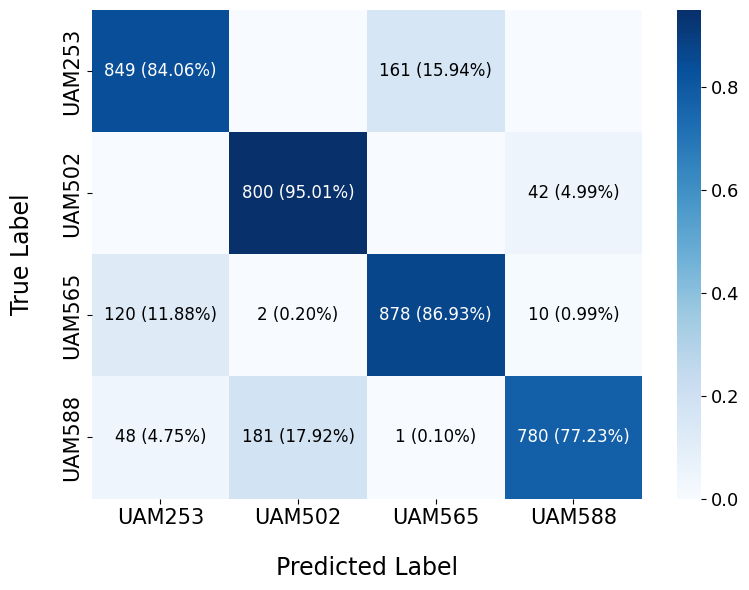

Class 0 - Accuracy: 0.92, Recall: 0.84, Precision: 0.83, Specificity: 0.94, F1-Score: 0.84, AUC: 0.9709
Class 1 - Accuracy: 0.94, Recall: 0.95, Precision: 0.81, Specificity: 0.94, F1-Score: 0.88, AUC: 0.9890
Class 2 - Accuracy: 0.92, Recall: 0.87, Precision: 0.84, Specificity: 0.94, F1-Score: 0.86, AUC: 0.9754
Class 3 - Accuracy: 0.93, Recall: 0.77, Precision: 0.94, Specificity: 0.98, F1-Score: 0.85, AUC: 0.9840


In [19]:
base_directory = "C:\\Users\\fmantecam\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\df_filtrados\\trained_models\\definitivo\\"

# Retrieve only the folder names within the directory
folder_names = [name for name in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, name))]

for name in folder_names:
    folder_path = os.path.join(base_directory, name)

    # Search for .h5 files in the folder
    h5_files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]

    if h5_files:
        print(f"Folder '{name}' contains .h5 files. Running analysis...")
        # Call the ejecutar_main function if there is a .h5 file in the folder
        ejecutar_main(ruta_csv_corrected_trainval, ruta_csv_corrected_test,
                      ruta_csv_baselines_trainval, ruta_csv_baselines_test,
                      ruta_csv_originals_trainval, ruta_csv_originals_test,
                      save_path, name, target_column='especie')
    else:
        print(f"Folder '{name}' does not contain .h5 files. Skipping...")
